In [1]:
## GLADE+ galaxy catalogue:
## Column 1 : GLADEno;          GLADE+ catalog number 
## Column 3 : GWGCname;         Name in the GWGC catalog
## Column 9 : RA                Right ascension in degrees
## Column 10: Dec               Declination in degrees
## Column 14: B_lumin             Absolute B magnitude
## Column 33: d_L               Luminosity distance in Mpc units
## Column 34: d_Lerr           Error of luminosity distance in Mpc units
## Column 36: Mst               Stellar mass in 10^10 M_Sun units
## Column 37: Mst_err           Absolute error of stellar mass in 10^10 M_Sun units
## Column 39: Merger_rate       Base-10 logarithm of estimated BNS merger rate in the galaxy in Gyr^-1 units
## Column 40: Merger_rate_error Absolute error of estimated BNS merger rate in the galaxy
## For GLADE+ 2.4:
## Column 1 : GLADEno;          GLADE+ catalog number 
## Column 2 : GWGCname;         Name in the GWGC catalog
## Column 7 : RA                Right ascension in degrees
## Column 8: Dec               Declination in degrees
## Column 14: B_Abs             Absolute B magnitude
## Column 9: d_L               Luminosity distance in Mpc units

In [2]:
## import packages, need healpy to read .fits files
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import h5py
from scipy import integrate
from astropy.cosmology import FlatLambdaCDM
import multiprocessing
import statistics

import psutil
pid = psutil.Process()

In [3]:
## the GW events we are going to use : for simplicity, for BNS events we only use high-spin analysis results
localisation_data_name = ['../../../GW170817/localisation/skymap.fits']
GW_post_name = ['../../../GW170817/localisation/IGWN-GWTC3p0-v1-GW200129_065458_PEDataRelease_mixed_nocosmo.h5']
#prior_name = ['../../../GW170817/prior/high_spin_PhenomPNRT_posterior_samples.dat']
GC_name = '../../../GC/GLADE_2.4.txt'
# set up the bin_num for later luminosity analysis
bin_num = 80
if_savetxt = 1 # do you want to save the txt files of the overall skymap, dL, ranking, and evidence
if_plot = 1 # do you want to plot the posterior skymap, the distribution of dL, list of the ranking


In [4]:
def luminosity_distance(z, H0):
    # z (float): The redshift.
    # H0 (float): The Hubble constant in units of km/s/Mpc.
    # The luminosity distance in units of Mpc.
 
    from scipy.integrate import quad
    from astropy.cosmology import FlatLambdaCDM
    
    # define the cosmology using the FlatLambdaCDM model from Astropy
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3)
    
    # define the integrand function
    def integrand(x):
        return 1.0 / np.sqrt(cosmo.Om(z) * (1.0 + x)**3 + (1.0 - cosmo.Om(z)))
    
    # integrate the function from 0 to z
    integral, error = quad(integrand, 0, z)
    
    # calculate the luminosity distance using the cosmological parameters
    DL = (1.0 + z) * cosmo.luminosity_distance(z).value
    
    return DL

In [5]:
## define a function that loads the localisation posterior from GW
def read_fits(filename):
    #memory_info = pid.memory_info()    
    #print(memory_info)
    
    skymap,header = hp.read_map(filename, h=True)
    dis_mu = hp.read_map(filename,field=1) # check the skymap header for more info
    dis_sigma = hp.read_map(filename,field=2)
    dis_norm = hp.read_map(filename,field=3)
    # Get the number of pixels in the map
    nside = hp.get_nside(skymap)
    npix = hp.nside2npix(nside)

    # Create an empty array to hold the coordinates
    coords = np.empty((2,npix))
    
    #memory_info = pid.memory_info()    
    #print(memory_info)

    # Loop over all the pixels in the map and get the coordinates
    for i in range(npix):
        theta, phi = hp.pix2ang(nside, i, nest=False)
        coords[0,i] = phi *  180 / np.pi # Right ascension
        coords[1,i] = (90 - theta * 180 / np.pi)  # Declination
    RA = coords[0,:]
    Dec = coords[1,:]
    
    #memory_info = pid.memory_info()    
    #print(memory_info)
    
    sky_threshold_percent = 1
    sky_threshold = np.percentile(skymap[skymap!=0], sky_threshold_percent) # find the meaningful positions in the skymap
    nz_positions = np.where(skymap>sky_threshold)[0]
    #print(len(nz_positions))
    RA_nz = RA[nz_positions];
    Dec_nz = Dec[nz_positions]; 
    skymap_nz = skymap[nz_positions]; 
    # dL_nz is the distribution of dL
    # For GW170817, it should be a guassian distribution for each pixel
    dis_mu_nz = dis_mu[nz_positions]
    dis_sigma_nz = dis_sigma[nz_positions]
    dis_norm_nz = dis_norm[nz_positions]
    
    #memory_info = pid.memory_info()
    #print(memory_info)
    
    dL_nz=[]
    for ipix in range(len(nz_positions)):
        mapind = nz_positions[ipix]
        #print(mapind)
        #print(nz_positions)
        #print(sky_threshold)
        mu = float(dis_mu[mapind])
        sigma = float(dis_sigma[mapind])
        norm = float(dis_norm[mapind])
        # the range of the distribution, we take 3 sigma of guassian distribution
        if np.isinf(mu):
            dL_range = np.linspace(1,200,num=200) # for the infinity mu case, we take the d^2 distribution
            delta_d = dL_range[1]-dL_range[0]
            dL_distribution = dL_range*dL_range/(sum(dL_range*dL_range)*delta_d)
        else:
            min_dL = mu - 3*sigma
            max_dL = mu + 3*sigma
            num = round((max_dL - min_dL)/0.2)
            dL_range = np.linspace(max([min_dL,0]),max_dL,num=num)
            dL_len = len(dL_range)
            dL_distribution = np.ones(dL_len)
            for i in range(dL_len):
                dL_distribution[i] = norm*np.exp(-0.5* ((dL_range[i] - mu)/sigma)**2)
        
        dL_nz.append([dL_range,dL_distribution])
        
    #memory_info = pid.memory_info()    
    #print(memory_info)
    return RA, Dec, skymap,RA_nz, Dec_nz, skymap_nz,dL_nz,nz_positions,nside,npix


In [6]:
def parse_float(x):
    if x == b'null':  # b'null' represents the byte-string 'null'
        return np.nan
    else:
        return float(x)
    
## define a function that loads the galaxy catalogue GC: GLADE 2.4
def read_gc_2(GC_name,nz_positions,GW_dL_nz,nside):
    full_GLADEno = np.loadtxt(GC_name, dtype = float, usecols=(0), converters={0: parse_float});
    full_GWGCname = np.loadtxt(GC_name, dtype = str, usecols=(1));
    full_z = np.loadtxt(GC_name, dtype = float, usecols=(10), converters={10: parse_float});
    full_d_L = np.loadtxt(GC_name, dtype = float, usecols=(8), converters={8: parse_float});
    full_d_L_err = np.loadtxt(GC_name, dtype = float, usecols=(9), converters={9: parse_float});
    full_RA = np.loadtxt(GC_name, dtype = float, usecols=(6), converters={6: parse_float});
    full_Dec = np.loadtxt(GC_name, dtype = float, usecols=(7), converters={7: parse_float});
    full_B_Abs = np.loadtxt(GC_name, dtype = float, usecols=(13), converters={13: parse_float});
    full_B_app = np.loadtxt(GC_name, dtype = float, usecols=(11), converters={11: parse_float});
    print('GC loaded')
    ## count the number of galaxies we needs
    GLADEno = []; GWGCname = []; RA = []; Dec = []; B_lumin = []; d_Lerr = [];z = [];
    d_L = []; Mst = []; Mst_err = []; Merger_rate = []; Merger_rate_error = [];GC_nzskymap = [];
    theta = ((90.0 - full_Dec)/180)*np.pi
    phi = (full_RA/180)*np.pi
    GC_pixel_pos = hp.ang2pix(nside, theta, phi)# where the galaxy is on the skymap
    # Find the same elements using boolean indexing
    GC_skymap = GC_pixel_pos[np.in1d(GC_pixel_pos, nz_positions)]
    # Which galaxies are selected, find their positions in the GC
    GC_indices = np.where(np.in1d(GC_pixel_pos, nz_positions))[0]
    
    # get the b band apparent magnitude threshold    
    nside_incomp = nside/16
    npix_incomp = hp.nside2npix(nside_incomp)
    B_apparent_list = [[] for _ in range(int(npix_incomp))]
    B_lumin_list = [[] for _ in range(int(npix_incomp))]
    B_threshold= np.zeros(int(npix_incomp))
    B_lumin_ipix= np.zeros(int(npix_incomp))
    B_app = full_B_app[GC_indices]
    #B_app_array = np.array(full_B_app)
    #B_app_nz = B_app_array[~np.isnan(B_app_array)]
    ipix_incomp = hp.ang2pix(int(nside_incomp), theta, phi)
    for i in range(len(theta)):
        if ~np.isnan(full_B_app[i]):
            B_apparent_list[ipix_incomp[i]].append(full_B_app[i])
        if ~np.isnan(full_B_Abs[i]):
            B_lumin_list[ipix_incomp[i]].append(10**(0.4*(4.83 - full_B_Abs[i])))
    for i in range(int(npix_incomp)):
        if len(B_apparent_list[i])==0:
            B_threshold[i] = -9999 # empty case
            B_lumin_ipix[i] = 0
        else:
            
            B_threshold[i] = statistics.median(B_apparent_list[i]) # the median b band apparent luminosity in each pixel
            B_lumin_ipix[i] = sum(B_lumin_list[i])
    #B_threshold = hp.ud_grade(B_threshold, nside) # upgrade the resolution to match the main skymap
    #B_threshold_nz = B_threshold[nz_positions]    
        
        
        
    print("The number of the in-pixel galaxies are",len(GC_indices))
    d_temp = full_d_L[GC_indices]; d_temp_err = full_d_L_err[GC_indices];
    
     
    for i in range(len(GC_indices)):
        nz_pixel_pos = int(np.where(nz_positions==GC_skymap[i])[0])
        if_indistance = (d_temp[i])>min(GW_dL_nz[nz_pixel_pos][0]) and (d_temp[i])<max(GW_dL_nz[nz_pixel_pos][0])
        if  if_indistance: 
            GC_pos = GC_indices[i]
            B_luminosity = 10**(0.4*(4.83 - full_B_Abs[GC_pos])) # calculating luminosity from magnitude
            GLADEno.append(full_GLADEno[GC_pos]); GWGCname.append(full_GWGCname[GC_pos]); 
            RA.append(full_RA[GC_pos]);Dec.append(full_Dec[GC_pos]); 
            B_lumin.append(B_luminosity); d_L.append(full_d_L[GC_pos]); 
            z.append(full_z[GC_pos]); GC_nzskymap.append(float(nz_pixel_pos)); 
    
    full_B_lumin = 10**(0.4*(4.83 - full_B_Abs)) # calculating luminosity from magnitude  

    print("The number of the used galaxies are",len(GC_nzskymap))
    print("Galaxies selected")
    return GLADEno,GWGCname,RA,Dec,B_lumin,B_threshold,B_lumin_ipix,d_L,z,GC_nzskymap,full_B_lumin

#GLADEno,GWGCname,GC_RA,GC_Dec,B_lumin,appthr,B_lumin_ipix,GC_dL,z,GC_nzskymap,full_B_lumin = read_gc_2(GC_name,nz_positions,GW_dL_nz,nside)


In [7]:
## define a function that calculates the Multi-Messenger Prior Func (MMPF)
## We assume complete GC
def mmpf(B_lumin,nz_positions,full_B_lumin):    
    N = len(B_lumin) # we have N galaxies considered here
    MMPF_GC = np.zeros(N)
    B_lumin_array = np.array(B_lumin)
    full_B_lumin_array = np.array(full_B_lumin)
    full_B_lumin_nz = full_B_lumin_array[~np.isnan(full_B_lumin_array)]
    weighting_norm = sum(full_B_lumin_nz)
    # for every galaxy, we attribute it a weight
    for i in range(N):
        if np.isnan(B_lumin_array[i]):
            MMPF_GC[i] = 0
        else:
            weighting = (B_lumin_array[i]/weighting_norm)
            MMPF_GC[i] = weighting
        
    
    return MMPF_GC

In [8]:
## define the schechter function
def schechter(distance, appthr):

    c = 3e5 # km/s
    pc = 3.086e16 # meters
    Mpc = 1e6 * pc # meters
    H_0 = 70 # Hubble constant
    h = H_0/100
    L0 = 3.828e26  # luminosity of the Sun in W
    L_star = 1.2e10*(h**(-2))*L0
    phi_star = 1.6e-2*(h**3) # phi star in h^3
    alpha = -1.07
    absthr = appthr - 5 * np.log10(distance) - 25 
    min_L = 0.001*L_star
    thr_L = max([(10**(0.4*(4.83 - absthr)))*L0,min_L])
    max_L = np.inf
    # P(G|CsI) is defined the same as it in the O3 paper: N_obs/N_all
    n = lambda L: phi_star * (L/L_star)**alpha * np.exp(-L/L_star)
    n_obs = integrate.quad(n, thr_L, max_L)[0] *(distance**2)
    n_all = integrate.quad(n, min_L, max_L)[0] *(distance**2)
    return n_obs,n_all

In [10]:
## define a function that calculates the GW posteriors for the positions of the galaxies
def gw_post_forGC(GW_RA_nz,GW_Dec_nz,GW_dL_nz,GW_skymap_nz,GC_nzskymap,GC_dL_nz,nz_positions,npix):    
    N = len(GC_dL) # we have N galaxies considered here
    GW_GC = np.zeros(N)
    
    # for every galaxy, we calculate the GW posterior probability of its position
    for i in range(N):
        pixel_ind = int(GC_nzskymap[i])
        pixel_prob = GW_skymap_nz[pixel_ind]/(4*np.pi/npix)
        # for the luminosity distribution, we use linear interpolation of the kernel density funtion of the GW samples
        distance_prob = np.interp(GC_dL_nz[i],GW_dL_nz[pixel_ind][0],GW_dL_nz[pixel_ind][1])
        GW_GC[i] = pixel_prob*distance_prob
        
        #print(sum((GW_dL_nz[pixel_ind][0][1]-GW_dL_nz[pixel_ind][0][0])*GW_dL_nz[pixel_ind][1]))
    
    return GW_GC

Now reading localisation data...
Now reading GC: GLADE 2.4...
GC loaded
The number of the in-pixel galaxies are 710484
The number of the used galaxies are 1671
Galaxies selected
Computing MMPF...
Computing GW posterior for each galaxy position...
Now calculating final posterior...
The most possible hosting galaxies for this GW event are :
[(  45657, 'NGC4993', 1120612,  41.776043 , 8.1253110e+09, 0.14295122)
 (  45738, 'ESO508-024', 1128283,  29.063831 , 6.3492147e+09, 0.13860828)
 (  45514, 'IC4197', 1126997,  41.058624 , 1.0251798e+10, 0.08773769) ...
 (      0, 'null', 1016891, 118.41499  , 8.2186409e+09, 0.        )
 (1079826, 'PGC1079826',  826660,  83.435936 , 1.4174900e+09, 0.        )
 (      0, 'null',  190121,   1.3194108,           nan, 0.        )]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


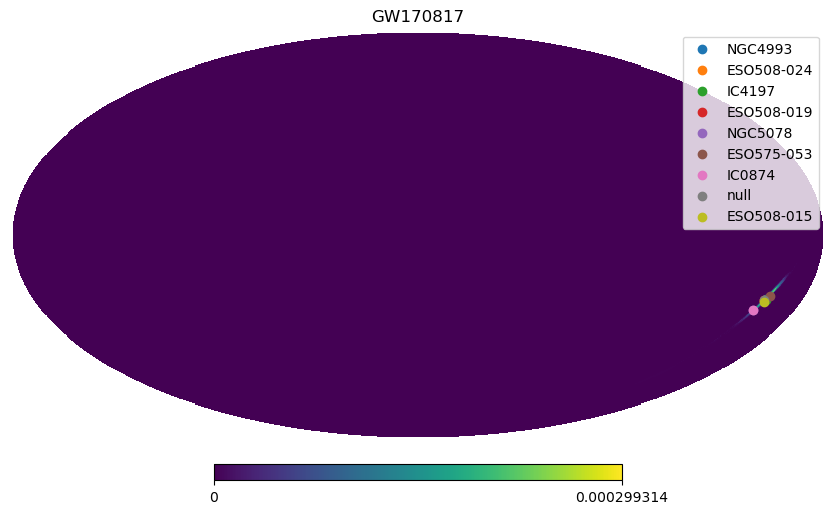

In [11]:
## the complete GC case
## set up the final output: posteriors of skymaps, B_lumin and dL, etc
post_skymap = [] 
post_dL = [] 
post_B_lumin = [] 
ranking= [] 
ranking_incomp= [] 
evidence_Mb = [] # evidence of taking M_b into account
evidence_Mb_incomp = [] 
## loop for every event we have
for idata in range(len(GW_post_name)):
    
    localisation_data = localisation_data_name[idata]
   
    print('Now reading localisation data...')
    # for GW localisation fits files, we read the posterior localisation results (the sky map)
    GW_RA, GW_Dec, GW_skymap,GW_RA_nz, GW_Dec_nz, GW_skymap_nz, GW_dL_nz,nz_positions,nside,npix = read_fits(localisation_data)

    print('Now reading GC: GLADE 2.4...')
    # load the galaxy catalogue GC
    GLADEno,GWGCname,GC_RA,GC_Dec,B_lumin,appthr,B_lumin_ipix,GC_dL,z,GC_nzskymap,full_B_lumin = read_gc_2(GC_name,nz_positions,GW_dL_nz,nside)
    
    print('Computing MMPF...')
    # get the MMPF
    MMPF_GC = mmpf(B_lumin,full_B_lumin,nz_positions)

    print('Computing GW posterior for each galaxy position...')
    GW_GC = gw_post_forGC(GW_RA_nz,GW_Dec_nz,GW_dL_nz,GW_skymap_nz,GC_nzskymap,GC_dL,nz_positions,npix)

    ## load the priors from LAL_inference package (by John)
    # for LAL_inference package, the prior for ra and dec is uniform acoross the sky (isotropy), so this will just be normalised
    # and the probability distribution of luminosity distance increases with dL^2 from 1 mpc to max designed range
    # the mass prior, the component mass is uniform distribution from 1 solar mass to 30, total mass less than 35
    GC_dL = np.array(GC_dL)
    PR_GW = np.ones(len(GC_nzskymap));
    min_pr_range = 1 #minimum range, from John's LAL paper
    max_designed_range = 200
    distance_norm = 3/(max_designed_range**3-min_pr_range**3)
    PR_GW = (1/(4*np.pi)) * GC_dL*GC_dL*distance_norm

    print('Now calculating final posterior...')    
    ## now compute the final posterior

    # ranking of galaxies
    ranking_idata = np.zeros(len(GC_nzskymap), dtype=[('index', 'i4'), ('name', 'U10'), ('pos', 'i4'), ('dL', 'f4'), ('B_lumin', 'f4'), ('prob', 'f4')])
    gala_probability = MMPF_GC*GW_GC/PR_GW
    # store the results
    for i in range(len(GLADEno)):
        if np.isnan(GLADEno[i]):
            GLADEno[i]=0
    ranking_idata['index'] = GLADEno
    ranking_idata['name'] = GWGCname
    ranking_idata['pos'] = GC_nzskymap
    ranking_idata['dL'] = GC_dL
    ranking_idata['B_lumin'] = B_lumin
    ranking_idata['prob'] = gala_probability

    sorted_indices = np.argsort(ranking_idata['prob'])[::-1]
    ranking_idata = ranking_idata[sorted_indices]
    
    # overall evidence
    evidence_Mb_idata = 0
    for i in range(len(GC_nzskymap)):
        evidence_Mb_idata += ranking_idata[i][5]
    for i in range(len(GC_nzskymap)):    
        ranking_idata[i][5] = ranking_idata[i][5]/evidence_Mb_idata

    ranking.append(ranking_idata)
    if (if_plot):
        print('The most possible hosting galaxies for this GW event are :')
        print(ranking_idata)
        GC_Dec_top = np.array(GC_Dec)[sorted_indices]
        GC_Dec_top = GC_Dec_top[0:9]
        GC_RA_top = np.array(GC_RA)[sorted_indices]
        GC_RA_top = GC_RA_top[0:9]
        GWGCname_top = np.array(GWGCname)[sorted_indices]
        GWGCname_top = GWGCname_top[0:9]
        hp.mollview(GW_skymap, title='GW170817')
        theta = ((90.0 - GC_Dec_top)/180)*np.pi
        phi = (GC_RA_top/180)*np.pi
        for i in range(len(theta)):
            hp.projscatter(theta[i], phi[i], marker='o')

        # Add a legend to the plot
        plt.legend(GWGCname_top)
        # Show the plot
        plt.savefig(str(idata)+'_ranking_'+'.eps', format='eps')
        plt.show()


    
    if (if_savetxt):
        fmt = '%d %s %d %.6f %.6f %.6f'
        np.savetxt(str(idata)+'_ranking'+'.txt', ranking_idata,fmt=fmt)

In [18]:
if (if_savetxt):
    fmt = '%d %s %d %.6f %.6f %.6f'
    np.savetxt(str(idata)+'_ranking_'+'.txt', ranking_idata,fmt=fmt)
    np.savetxt('evidence_Mb_'+'.txt', evidence_Mb)